## Entrainment of Gamma waves

I recorded EEG from myself while I listened to a 40-Hz sound produced by a small loudspeaker some 2-3 metres away 
-an iPhone with a sound generation App set to 40 Hz square wave. The App used is Thomas Gruber's "Function Generator".

There are three separate periods:
1. rest in silence for about 7 minutes
2. rest while sound is played, for about nine minutes
3. rest in silence for about 6 minutes

The EEG was recorded at 1000 Hz, on seven channels:  ['C3', 'C4', 'P3', 'P4', 'Fz', 'Cz', 'Pz']


In [2]:
import os.path as op
import numpy as np

import mne
from mne.channels import compute_native_head_t, read_custom_montage
from mne.viz import plot_alignment

import scipy
from scipy.signal import welch, blackman, stft
from scipy.fft import fft,rfft

import matplotlib
import matplotlib.pyplot as plt


In [3]:
## ## mne.viz.set_browser_backend( 'matplotlib')

In [11]:
#@title Figure Settings
import ipywidgets as widgets #interactive display

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
#-----

# Get Raw data. 

The whole session lasted less than 1500 seconds (or < 25 minutes).

Sampling frequency was 1000;

The Bittium Tesla amplifiers and NeurOne control equipment produces the output data 
in three separate files, in accordance with the "BrainVision" de-facto standard.

The mne interface knows how to deal with the three files.


In [5]:
raw = mne.io.read_raw_brainvision( "GammaTE.vhdr", preload=True)

Extracting parameters from GammaTE.vhdr...
Setting channel info structure...
Reading 0 ... 1409319  =      0.000 ...  1409.319 secs...


In [6]:
raw.info

<Info | 7 non-empty values
 bads: []
 ch_names: C3, C4, P3, P4, Fz, Cz, Pz
 chs: 7 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: unspecified
 nchan: 7
 projs: []
 sfreq: 1000.0 Hz
>

In [7]:
raw.ch_names

['C3', 'C4', 'P3', 'P4', 'Fz', 'Cz', 'Pz']

Take a look at the data:
There are no Stimuli or other markers in this file.  Just a single, raw recording.

In [8]:
# Since there are only a few channels and I only need the PSD, it isn't really
# worth doing these averages, but for consistency's sake
#
# Apply Projection: Average EEG reference:
# (Is this the right moment to apply a Projection ??) - we need one, though, at some point, for averaging.
raw.set_eeg_reference(ref_channels='average', projection=True ) # added as projection, not applied to data ...
_ = raw.apply_proj()                                            # ... applied to data

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


In [12]:
# coarse overview:
#
_ = raw.plot(duration=1400)

ValueError: Invalid value for the 'backend_name' parameter. Allowed values are 'qt' and 'matplotlib', but got 'pyvistaqt' instead.

Clearly, and as expected, there are three separate periods in the file:

1. about seven minutes (= 420 secs )  of "Before"
2. about nine minutes (= 540 secs) of "during audio signal"
3. about six minutes (= 360 secs) of "after" 

This makes around 1320 secs in total, leaving 89 seconds in total unaccounted for 
by imprecision, as we have recorded 1409 seconds worth of data.

From the plot above, we see that it is best to skip an interval around 420 Sec and 
again around 1000 secs.  Those correspond to the time I had to move to switch the 
sound generator on/off.  Also, at the very ends (both ends), there is disturbance
due to movement.  This was expected. 
  

In [13]:
# To be able to do plot with channel locations, I'll obviously need locations.  
# In this case, all the channels recorded are on the top of the head, 
# so this is somehat moot, but anyway:
#
dig_montage = read_custom_montage('BC-TMS-128.bvef', head_size=None, coord_frame='mri')
_ = raw.set_montage(dig_montage)

/var/folders/__/10wnymp572bd4t00q1ct9mfr0000gn/T/ipykernel_39578/1816778085.py:6: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  _ = raw.set_montage(dig_montage)


NOTE: plot_raw_psd() is a legacy function. New code should use Raw.compute_psd().plot().
Effective window size : 2.048 (s)
NOTE: plot_raw_psd() is a legacy function. New code should use Raw.compute_psd().plot().
Effective window size : 2.048 (s)
NOTE: plot_raw_psd() is a legacy function. New code should use Raw.compute_psd().plot().
Effective window size : 2.048 (s)
NOTE: plot_raw_psd() is a legacy function. New code should use Raw.compute_psd().plot().
Effective window size : 2.048 (s)


/var/folders/__/10wnymp572bd4t00q1ct9mfr0000gn/T/ipykernel_39578/2101361558.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/var/folders/__/10wnymp572bd4t00q1ct9mfr0000gn/T/ipykernel_39578/2101361558.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


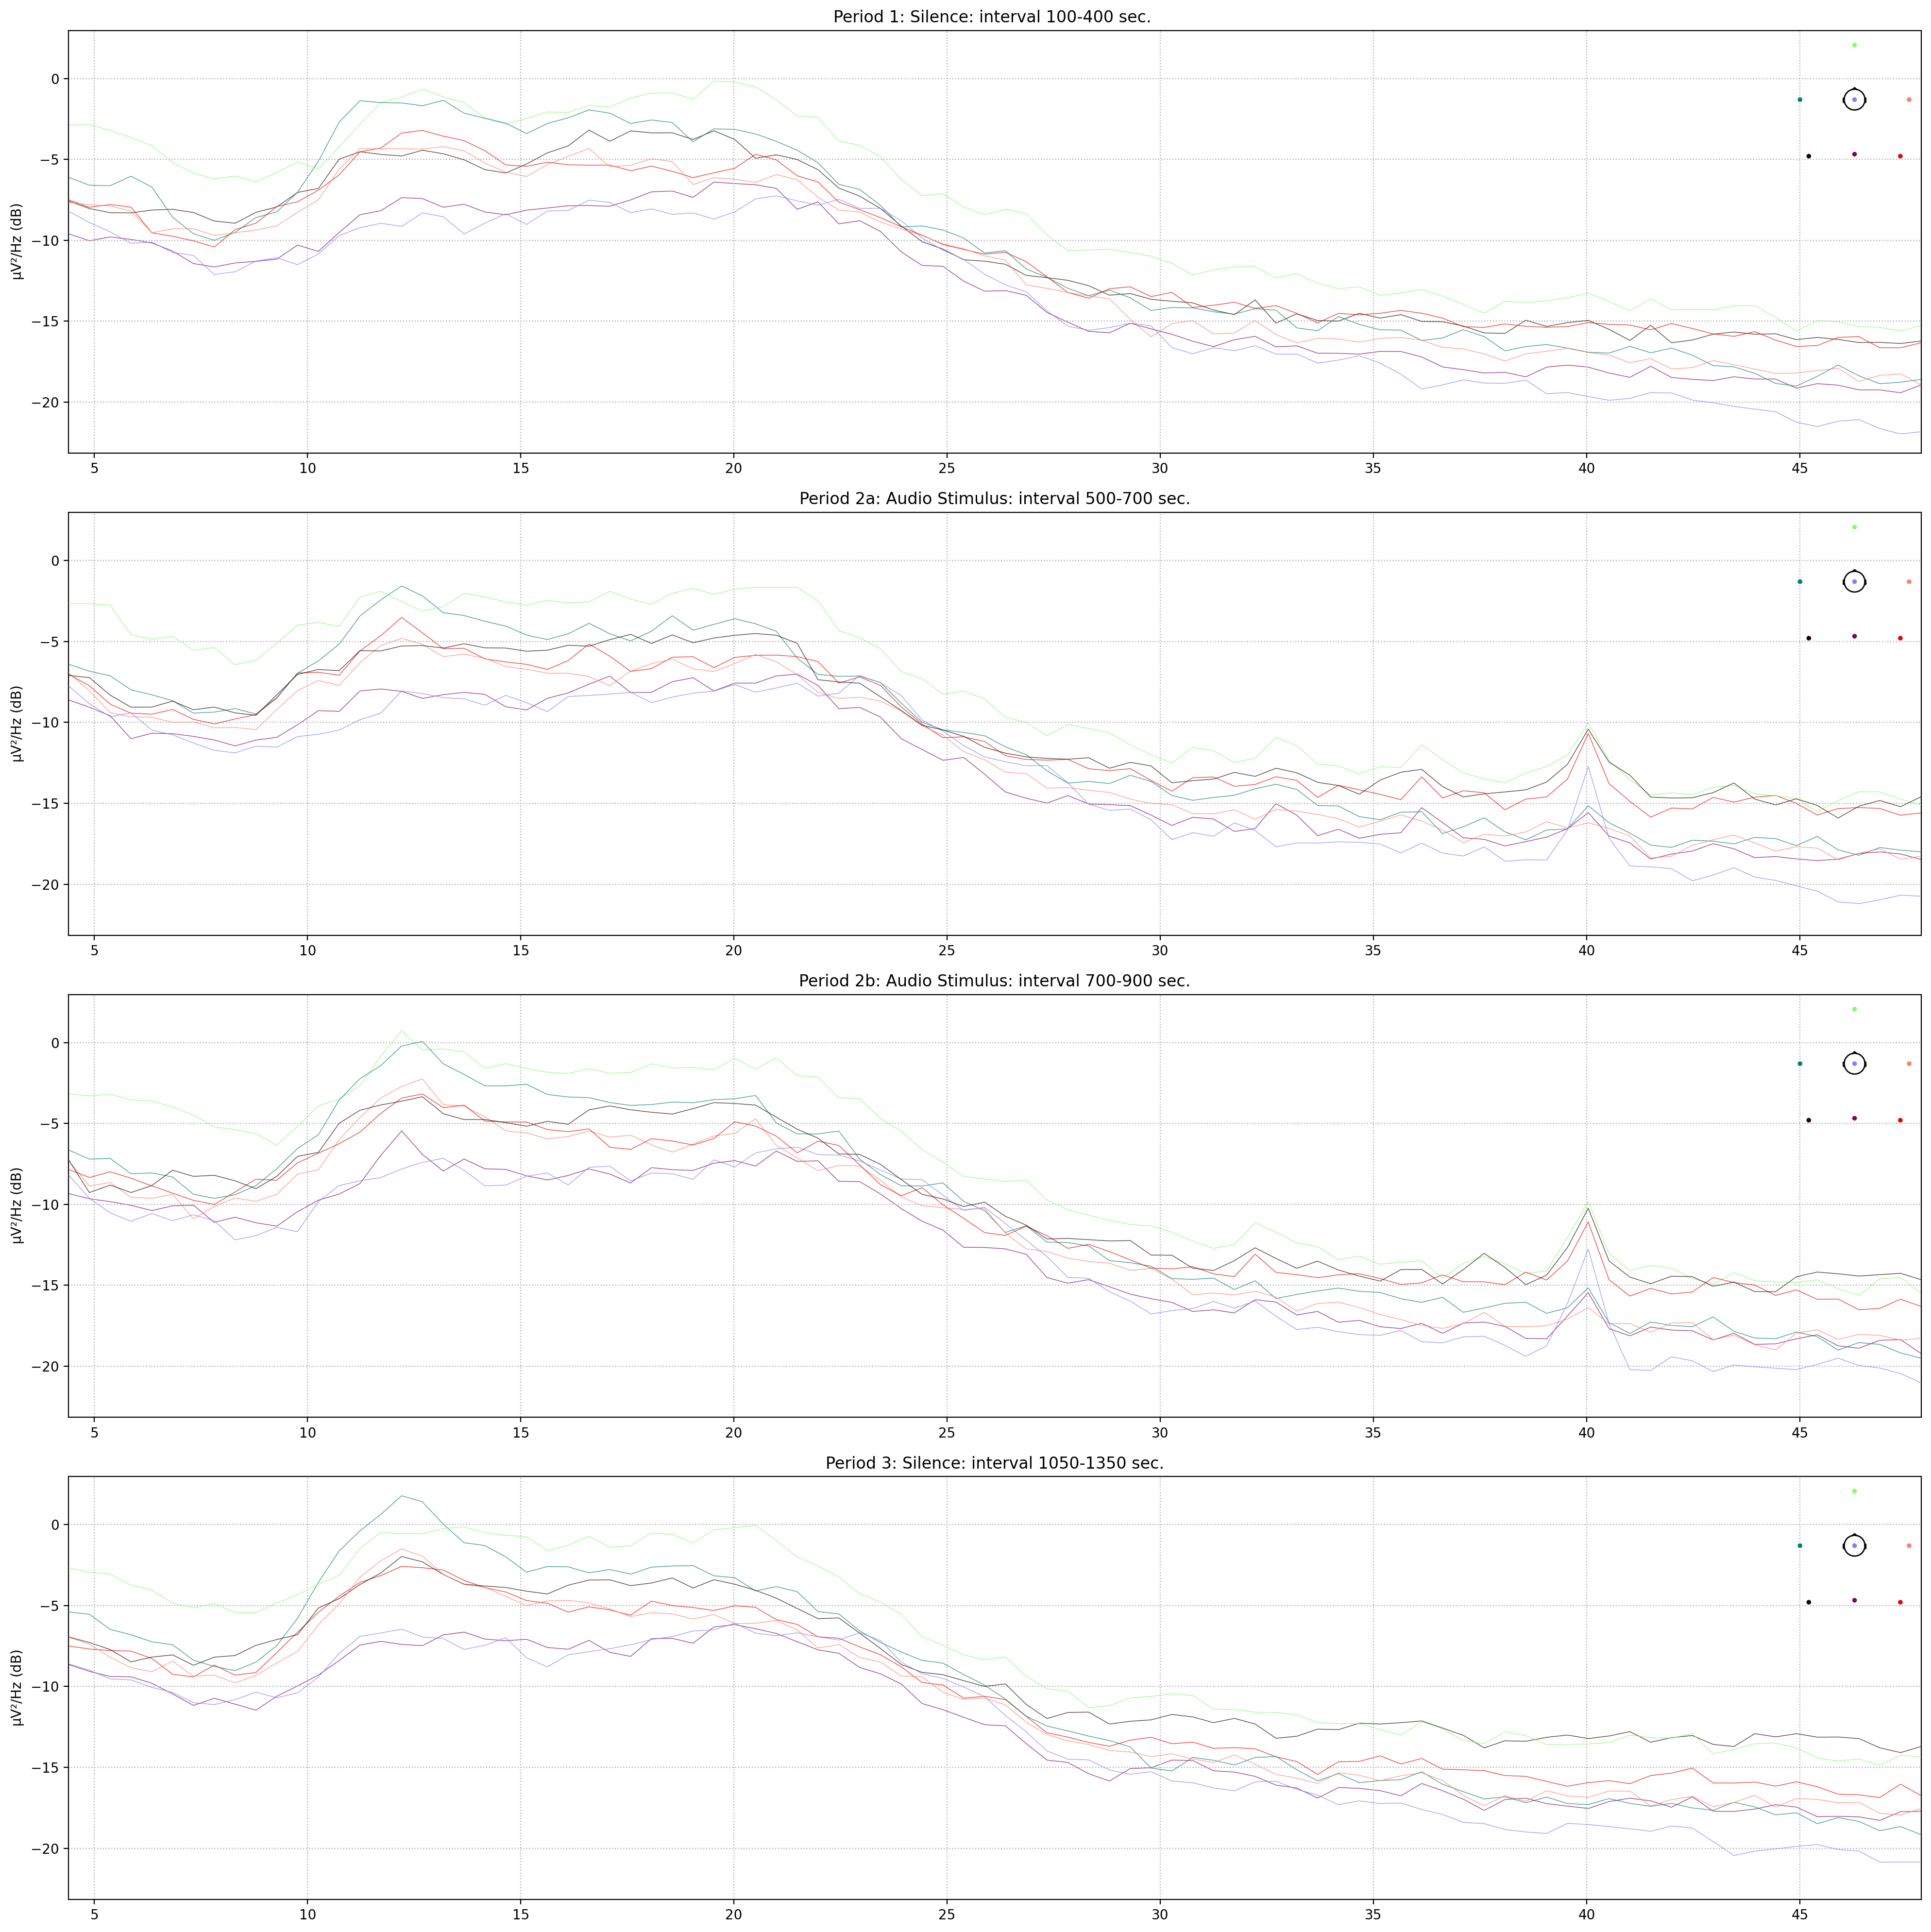

In [14]:
# Plot the PSDs of this data :
# I am interested in the low frequencies, between 4 and 48 Hz. only.

fig, ax = plt.subplots(4, sharey=True)  
fig.set_figheight( 20.) 
fig.set_figwidth( 20. )

_ = mne.viz.plot_raw_psd(raw,tmin=100,tmax=400,fmin=4.0,fmax=48.0, ax=ax[0], show=False)
ax[0].set_title('Period 1: Silence: interval 100-400 sec. ')

_ = mne.viz.plot_raw_psd(raw,tmin=500,tmax=700,fmin=4.0,fmax=48.0, ax=ax[1], show=False)
ax[1].set_title('Period 2a: Audio Stimulus: interval 500-700 sec.')

_ = mne.viz.plot_raw_psd(raw,tmin=700,tmax=900,fmin=4.0,fmax=48.0, ax=ax[2], show=False)
ax[2].set_title('Period 2b: Audio Stimulus: interval 700-900 sec.')

_ = mne.viz.plot_raw_psd(raw,tmin=1050,tmax=1350,fmin=4.0,fmax=48.0, ax=ax[3], show=False)
ax[3].set_title('Period 3: Silence: interval 1050-1350 sec.')

fig.tight_layout()  
fig.show()


In [15]:
# the Gamma effect died out very quickly, and the decrease period is difficult to separate 
# from the period of activity that caused a lot of noise.  
# Note that the Alpha peak grew a bit in the last image.  I don't know what that means. Relaxation? 

Effective window size : 2.048 (s)


/Users/edwald/python_venvs/meduni/lib/python3.9/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


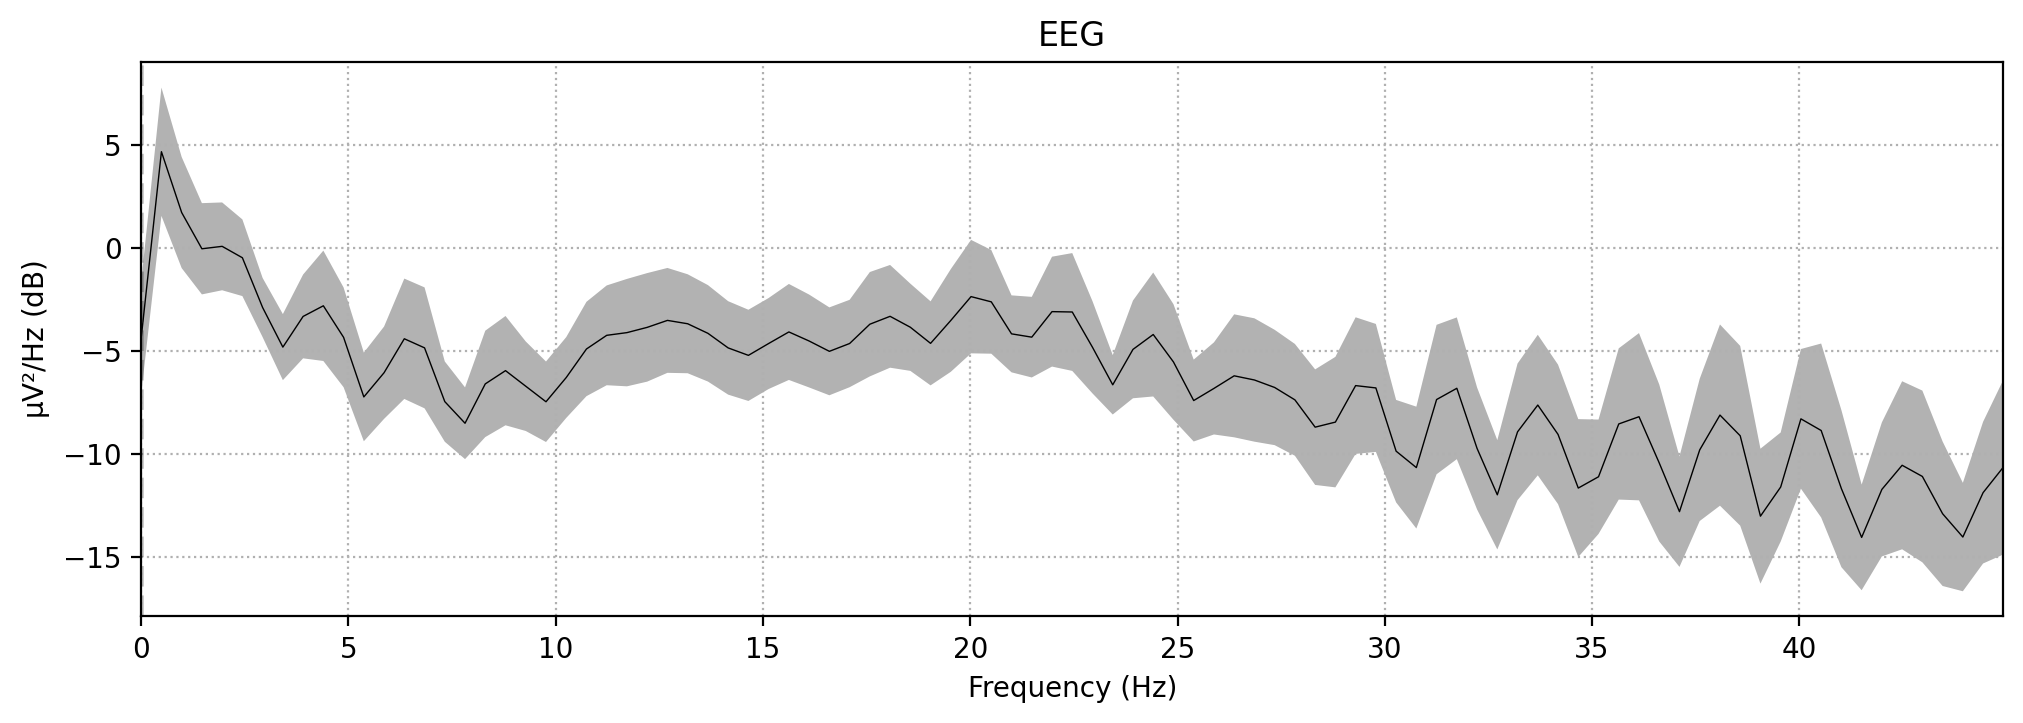

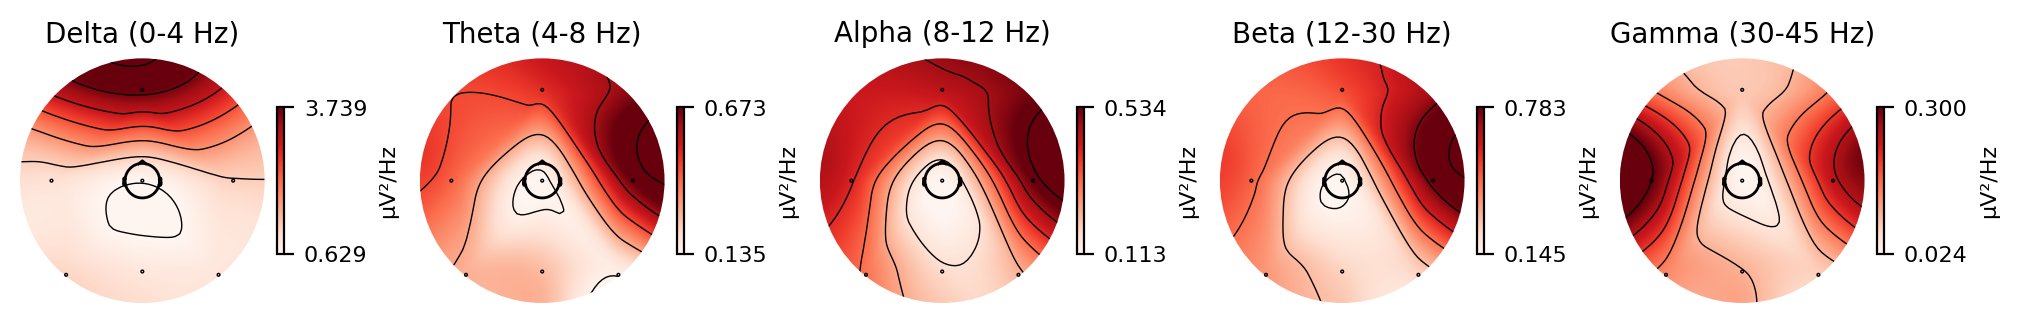

In [16]:
# cut the frequency interval to below 50 Hz
#
spectrum=raw.compute_psd( fmin=0, fmax=45)
_ = spectrum.plot(average=True, )
_ = spectrum.plot_topomap()

NOTE: plot_raw_psd() is a legacy function. New code should use Raw.compute_psd().plot().
Effective window size : 2.048 (s)
NOTE: plot_raw_psd() is a legacy function. New code should use Raw.compute_psd().plot().
Effective window size : 2.048 (s)
NOTE: plot_raw_psd() is a legacy function. New code should use Raw.compute_psd().plot().
Effective window size : 2.048 (s)
NOTE: plot_raw_psd() is a legacy function. New code should use Raw.compute_psd().plot().
Effective window size : 2.048 (s)


/var/folders/__/10wnymp572bd4t00q1ct9mfr0000gn/T/ipykernel_39578/770170824.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/var/folders/__/10wnymp572bd4t00q1ct9mfr0000gn/T/ipykernel_39578/770170824.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


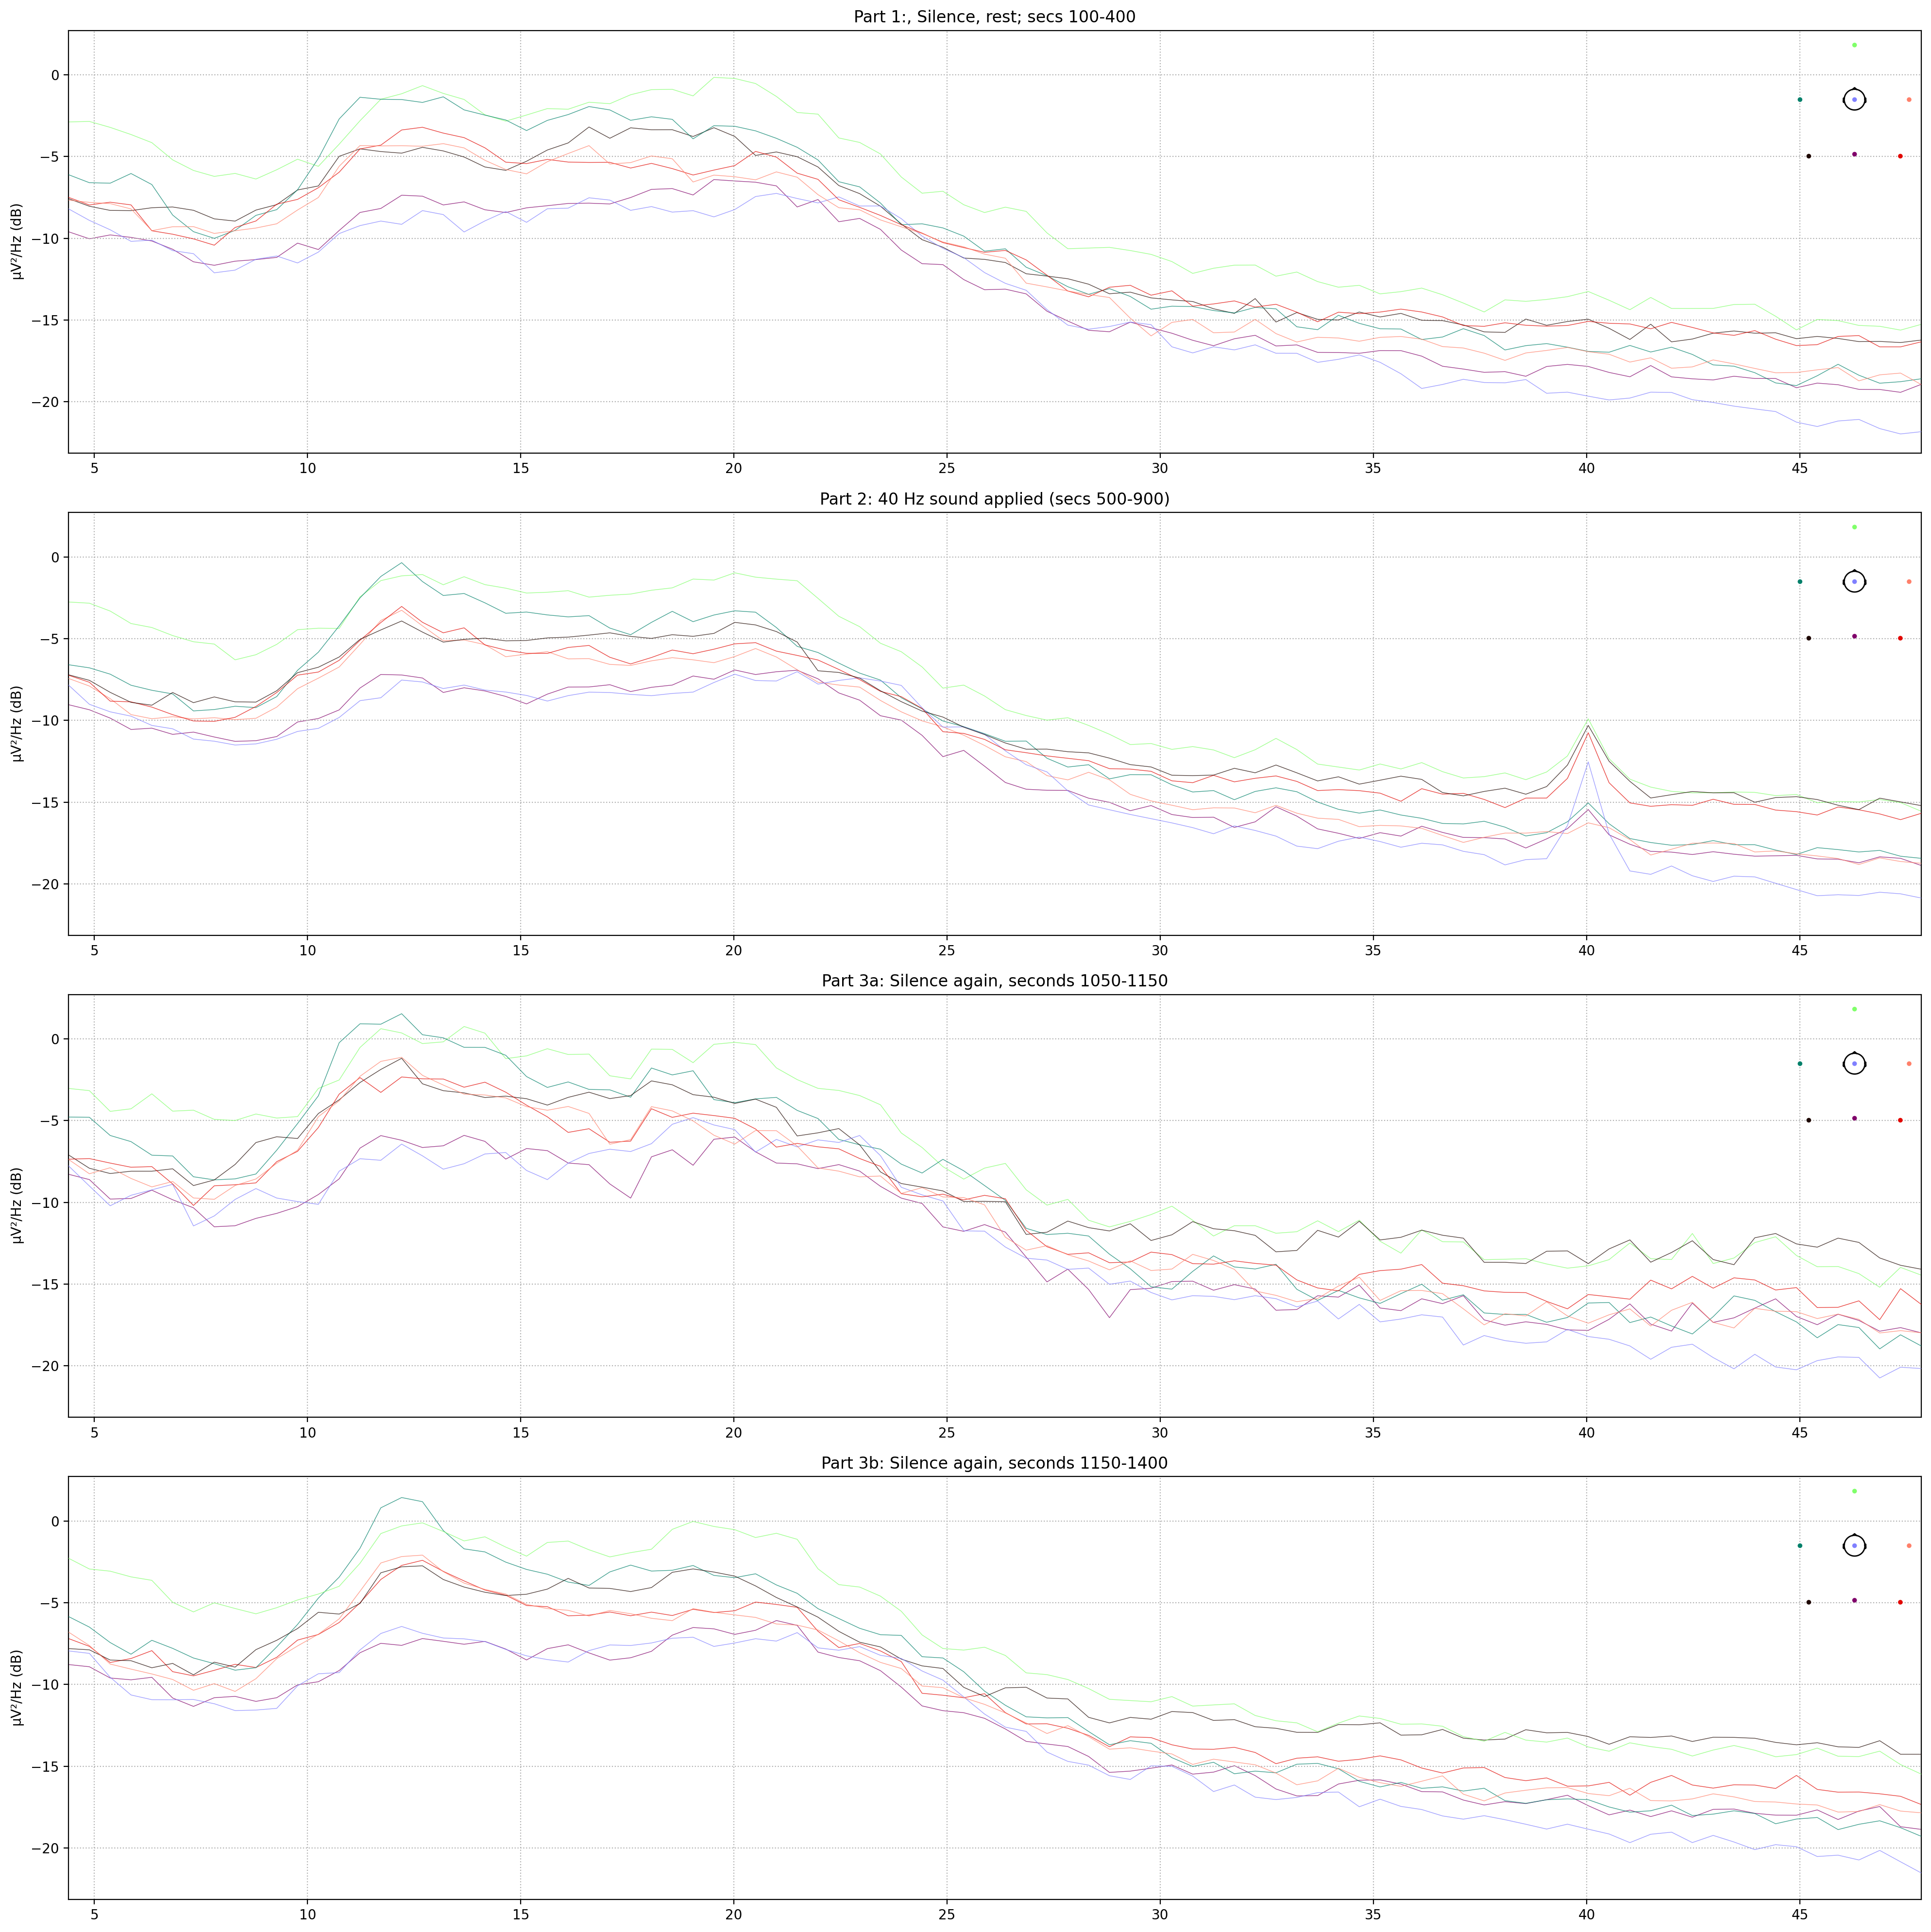

In [17]:

# note: -- not as impressive effect --

fig, ax = plt.subplots(4, sharey=True)  # In this example dataset, we have 3 channel types -> 3 axes required!

fig.set_figheight( 20.) 
fig.set_figwidth( 20. )

_ = mne.viz.plot_raw_psd(raw,tmin=100,tmax=400,fmin=4.0,fmax=48.0, ax=ax[0], show=False)
ax[0].set_title('Part 1:, Silence, rest; secs 100-400')

_ = mne.viz.plot_raw_psd(raw,tmin=500,tmax=900,fmin=4.0,fmax=48.0, ax=ax[1], show=False)
ax[1].set_title('Part 2: 40 Hz sound applied (secs 500-900)')

_ = mne.viz.plot_raw_psd(raw,tmin=1050,tmax=1150,fmin=4.0,fmax=48.0, ax=ax[2], show=False)
ax[2].set_title('Part 3a: Silence again, seconds 1050-1150')

_ = mne.viz.plot_raw_psd(raw,tmin=1100,tmax=1400,fmin=4.0,fmax=48.0, ax=ax[3], show=False)
ax[3].set_title('Part 3b: Silence again, seconds 1150-1400')

fig.tight_layout()  
fig.show()

## Time-Frequency
Attempt to show a time-frequency graphic of some sort 

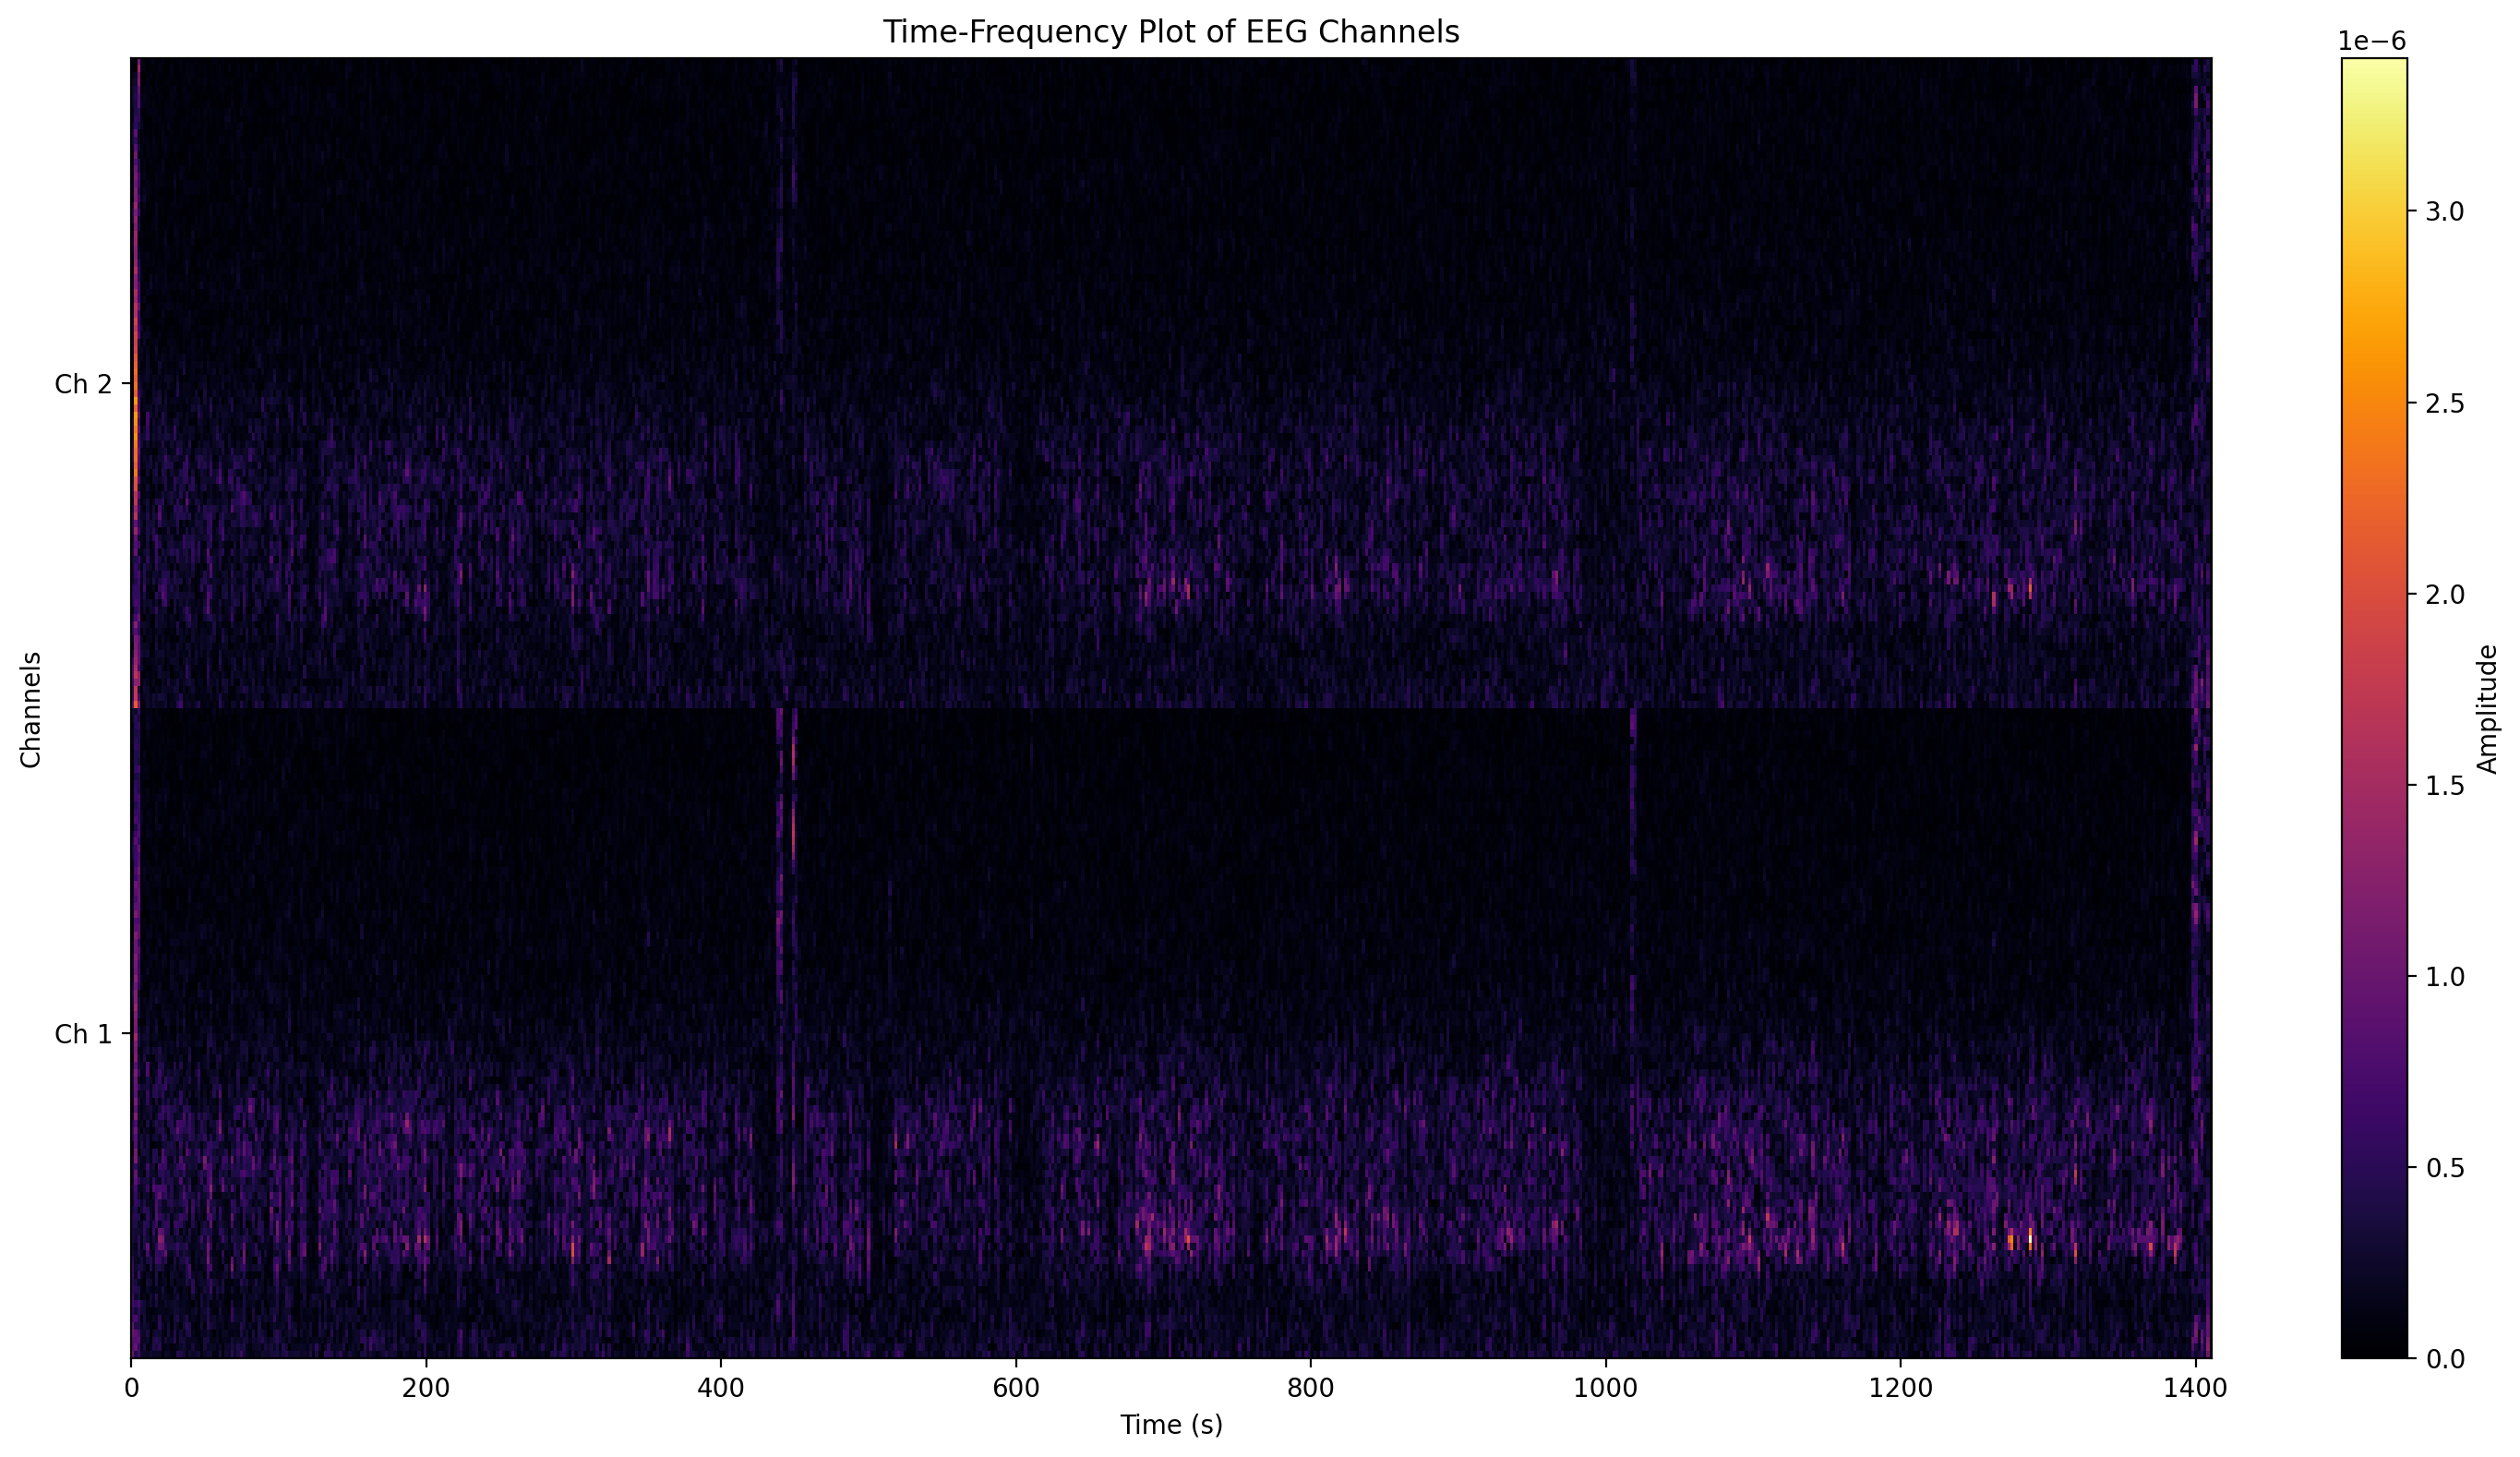

In [18]:
# Attempt to plot a time-frequency image of some sort
#
n_channels = 2
sampling_rate = 1000  # Hz
duration = 1409  # seconds
n_samples = sampling_rate * duration

# Generate random EEG data for demonstration
eeg_data = raw.get_data()

# Define parameters for STFT
frequencies = (4, 48)  # Frequency range in Hz
window = 'hann'        # Window type
nperseg = 2048         # Length of each segment in samples
noverlap =   0         # Overlap between segments

# Initialize a matrix to store the combined time-frequency data
# for plotting all channels in a single image
all_channel_tfr = []

# Compute STFT for each channel and stack results
for i in range(n_channels):
    # Perform STFT
    f, t, Zxx = stft(eeg_data[i], fs=sampling_rate, window=window, nperseg=nperseg, noverlap=noverlap)
    
    # Restrict frequencies to the desired range
    freq_mask = (f >= frequencies[0]) & (f <= frequencies[1])
    f = f[freq_mask]
    Zxx = Zxx[freq_mask, :]
    
    # Append the absolute amplitude of Zxx to the matrix
    all_channel_tfr.append(np.abs(Zxx))

# Convert to a 2D matrix for plotting (combine across channels)
all_channel_tfr = np.vstack(all_channel_tfr)

# Plotting
fig, ax = plt.subplots(figsize=(15, 8))
pcm = ax.imshow(all_channel_tfr, aspect='auto', extent=[t[0], t[-1], 0, n_channels], origin='lower', cmap='inferno')

# Add labels and formatting
ax.set_title('Time-Frequency Plot of EEG Channels')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Channels')
ax.set_yticks(np.arange(n_channels) + 0.5)  # Center tick marks for each channel
ax.set_yticklabels([f'Ch {i+1}' for i in range(n_channels)])
fig.colorbar(pcm, ax=ax, orientation='vertical', label='Amplitude')

plt.tight_layout()
plt.show()


This is somewhat disappointing;

The vertical bands at approximately. 420 and around 1000 seconds, as well as the end around 1400 
is caused by movement when I needed to start/stop  the sound generation 

NOTE: plot_raw_psd() is a legacy function. New code should use Raw.compute_psd().plot().
Effective window size : 2.048 (s)
NOTE: plot_raw_psd() is a legacy function. New code should use Raw.compute_psd().plot().
Effective window size : 2.048 (s)
NOTE: plot_raw_psd() is a legacy function. New code should use Raw.compute_psd().plot().
Effective window size : 2.048 (s)


/var/folders/__/10wnymp572bd4t00q1ct9mfr0000gn/T/ipykernel_39578/1793907795.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/var/folders/__/10wnymp572bd4t00q1ct9mfr0000gn/T/ipykernel_39578/1793907795.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


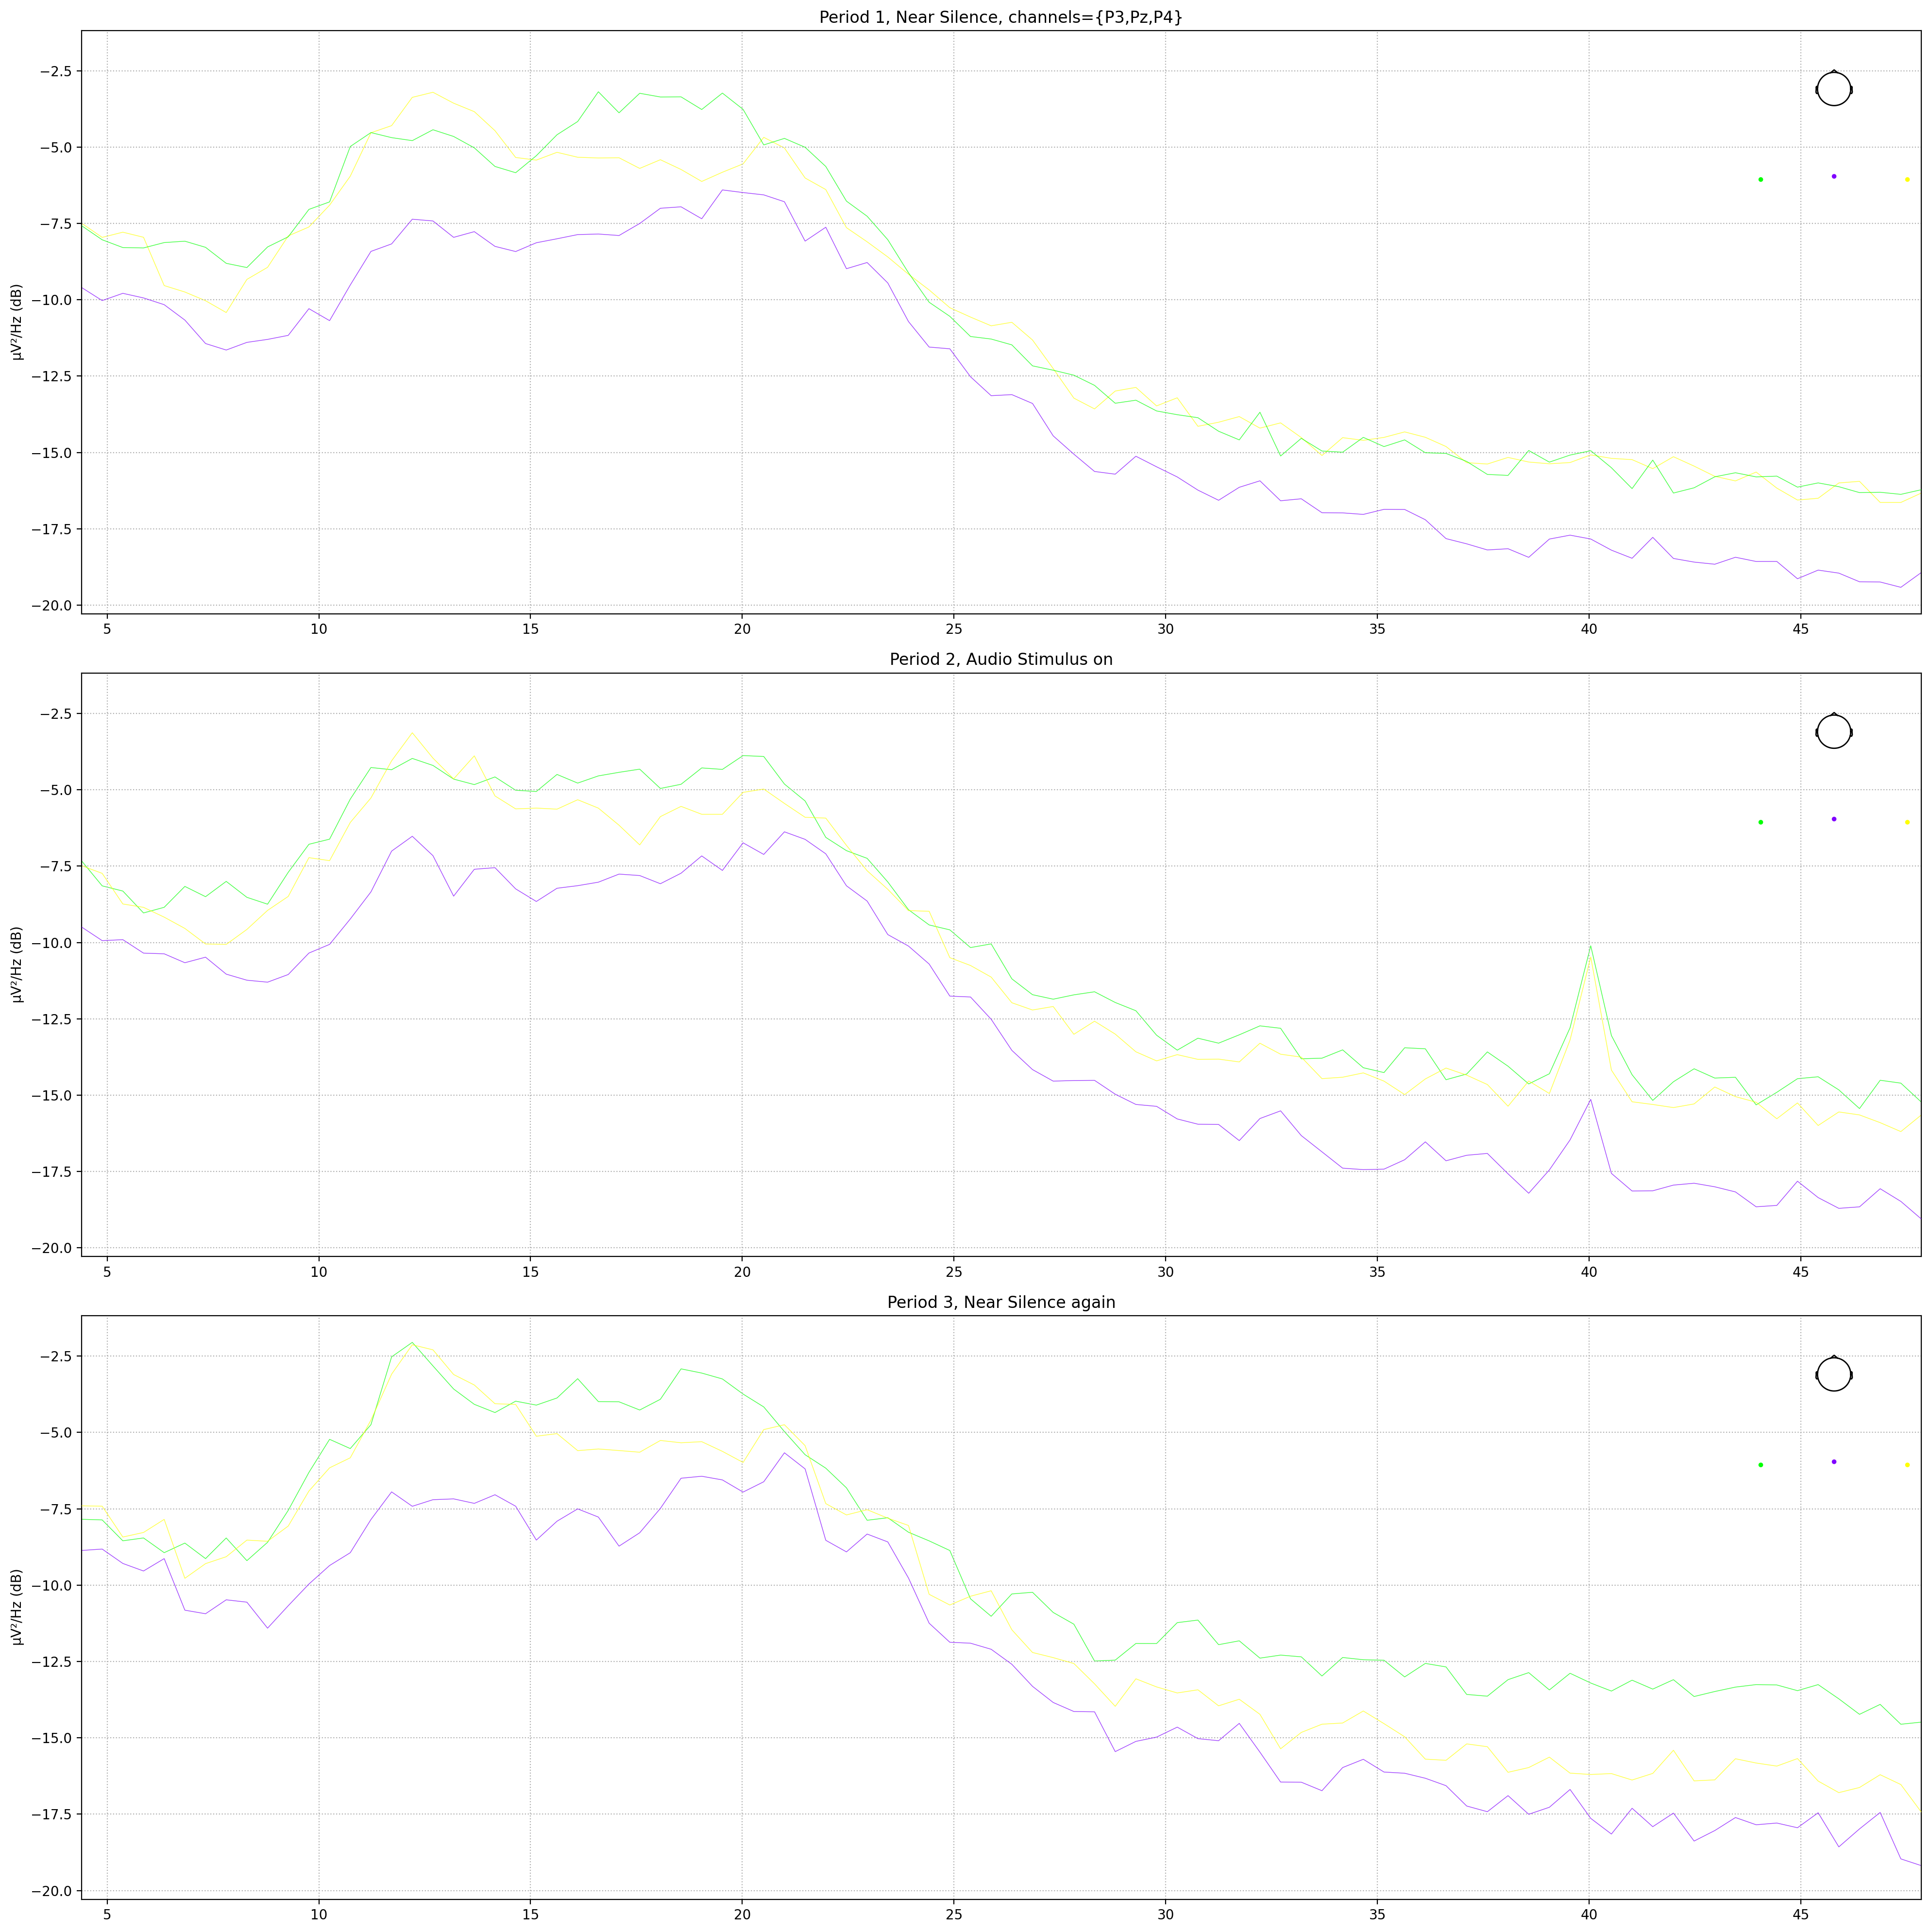

In [19]:
# Parietal lobe -block:
# The effect is quite clear here
#
fig, ax = plt.subplots(3, sharey=True) 

fig.set_figheight( 20.) 
fig.set_figwidth( 20. )

_ = mne.viz.plot_raw_psd(raw,tmin=100,tmax=400,fmin=4.0,fmax=48.0,picks=['P3','Pz','P4'], ax=ax[0], show=False)
ax[0].set_title('Period 1, Near Silence, channels={P3,Pz,P4}' )

_ = mne.viz.plot_raw_psd(raw,tmin=600,tmax=900,fmin=4.0,fmax=48.0,picks=['P3','Pz','P4'], ax=ax[1], show=False)
ax[1].set_title('Period 2, Audio Stimulus on')

_ = mne.viz.plot_raw_psd(raw,tmin=1100,tmax=1300,fmin=4.0,fmax=48.0,picks=['P3','Pz','P4'], ax=ax[2], show=False)
ax[2].set_title('Period 3, Near Silence again')


fig.tight_layout()  
fig.show()




NOTE: plot_raw_psd() is a legacy function. New code should use Raw.compute_psd().plot().
Effective window size : 2.048 (s)
NOTE: plot_raw_psd() is a legacy function. New code should use Raw.compute_psd().plot().
Effective window size : 2.048 (s)
NOTE: plot_raw_psd() is a legacy function. New code should use Raw.compute_psd().plot().
Effective window size : 2.048 (s)


/var/folders/__/10wnymp572bd4t00q1ct9mfr0000gn/T/ipykernel_39578/195238216.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/var/folders/__/10wnymp572bd4t00q1ct9mfr0000gn/T/ipykernel_39578/195238216.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


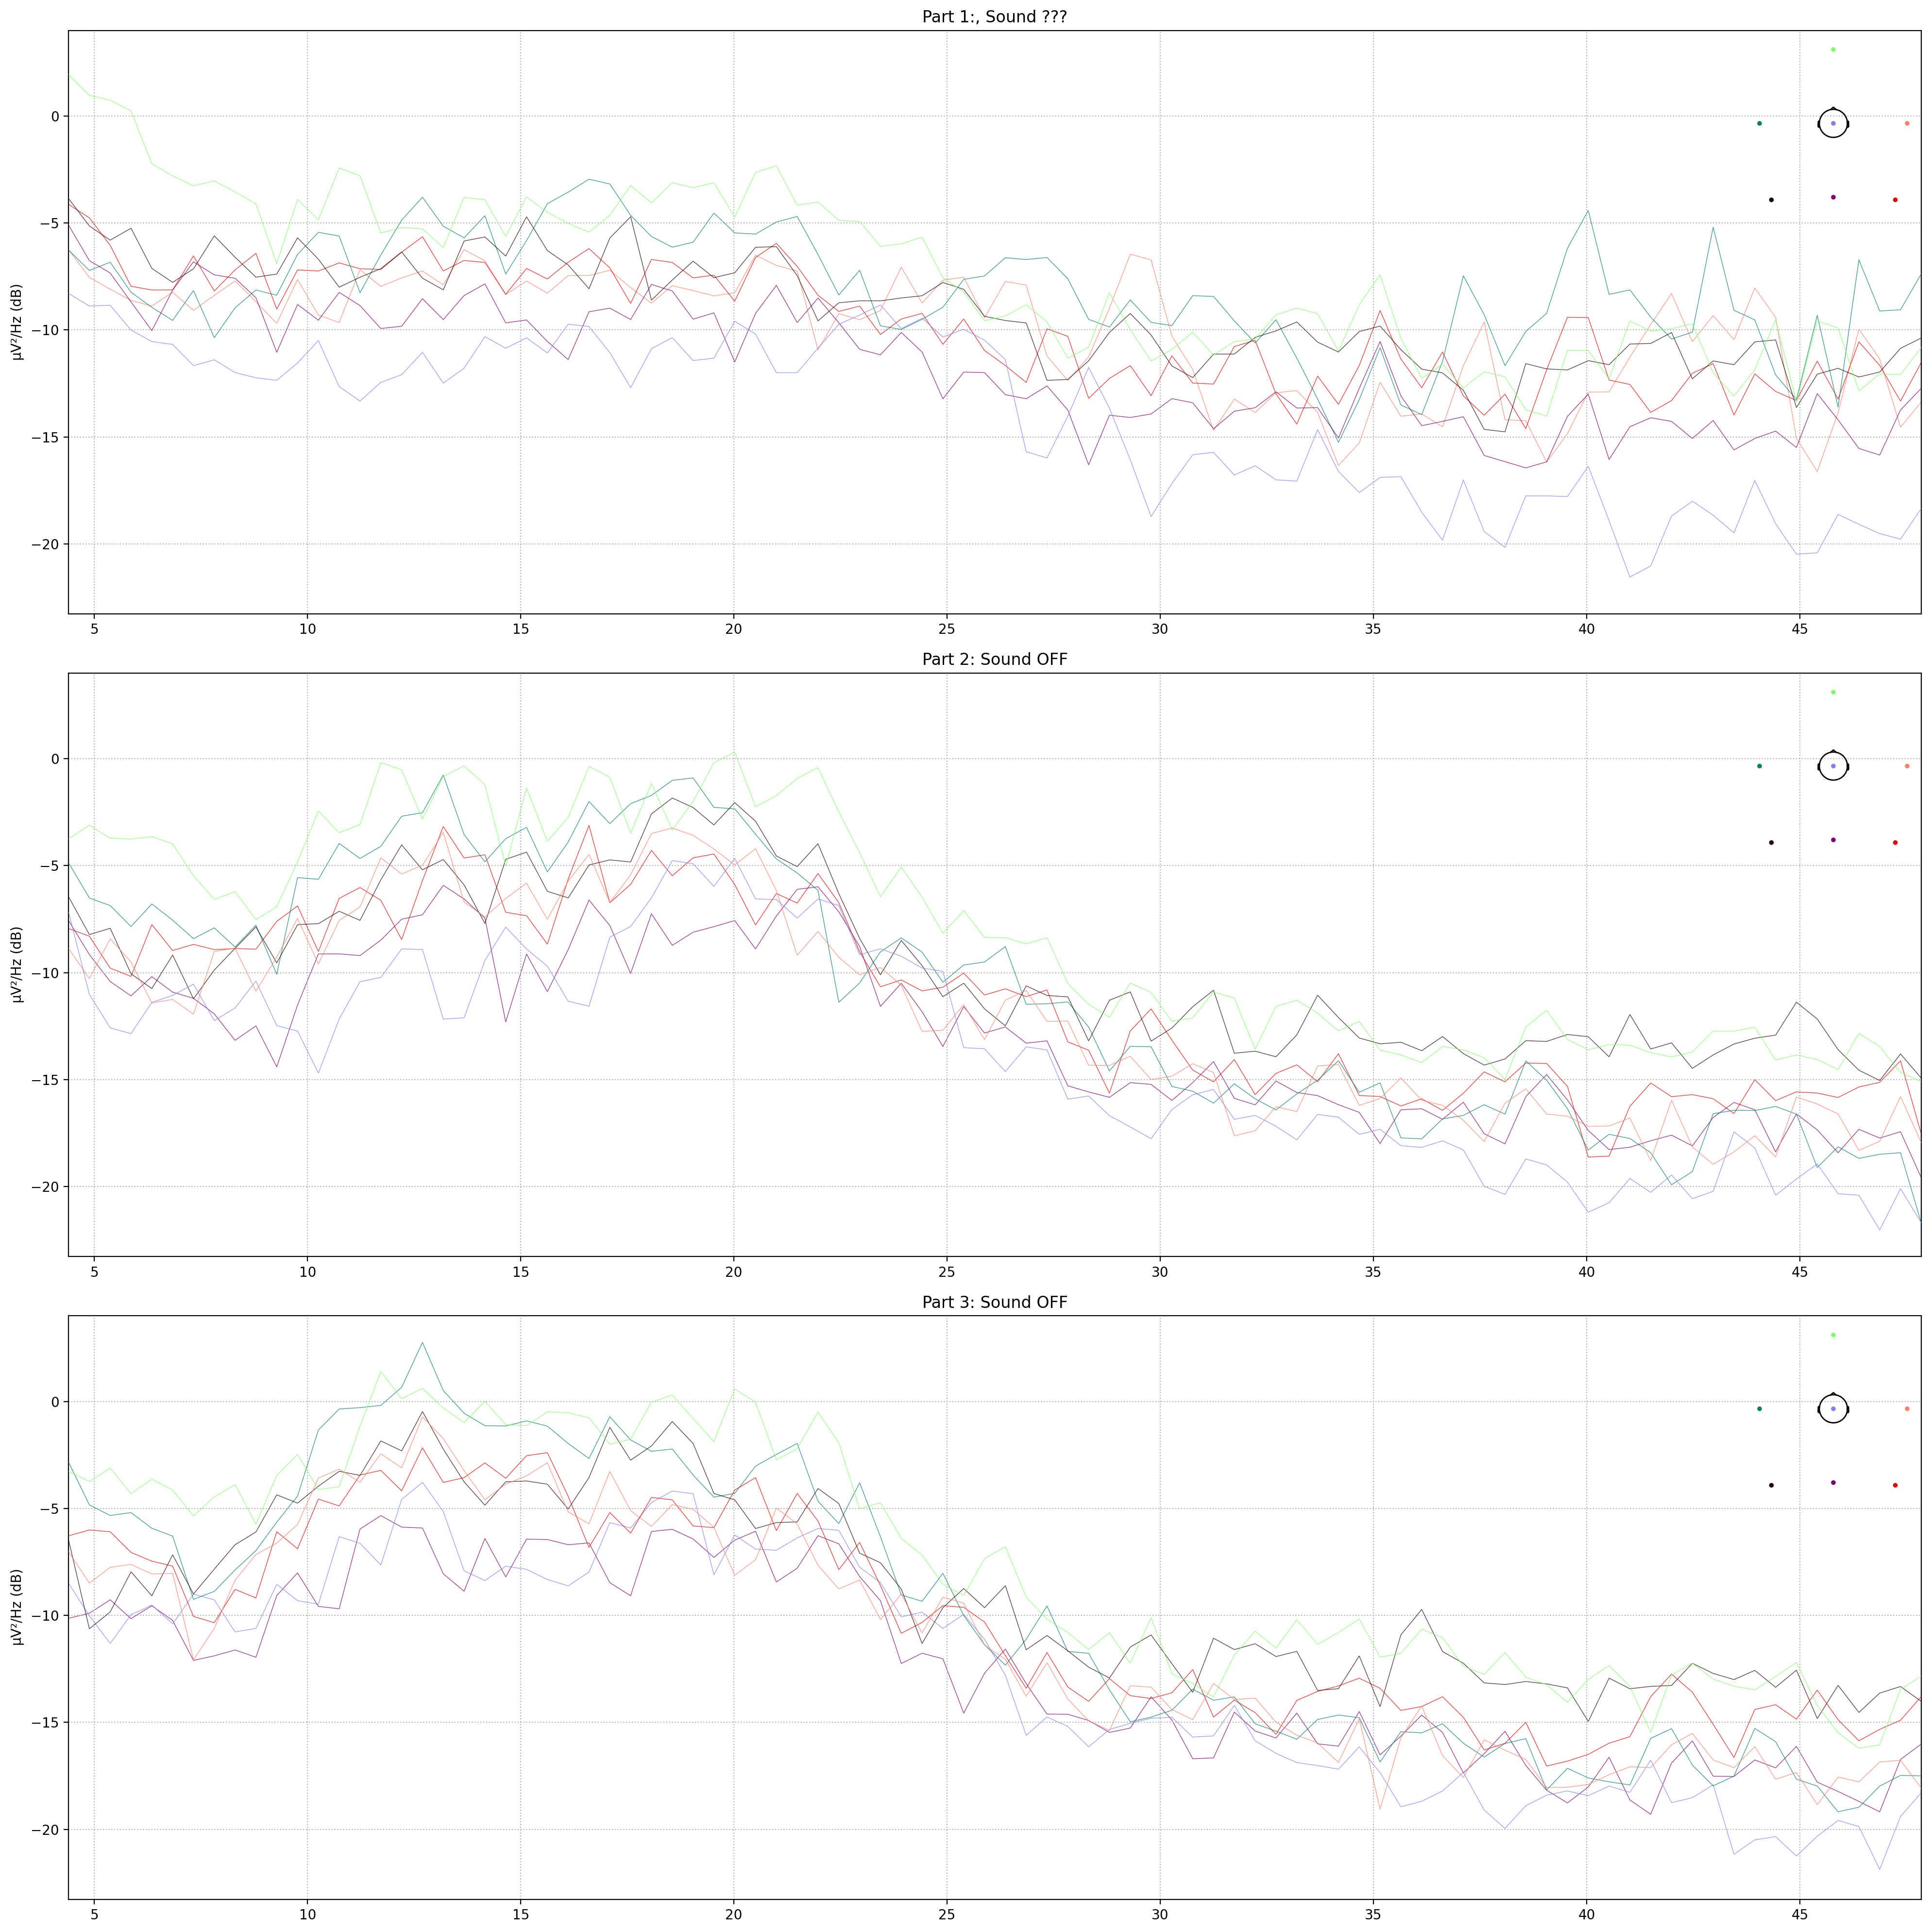

In [24]:
# try to pinpoint where the Gamma effect dies out 
#
# note: -- not as impressive effect --

fig, ax = plt.subplots(3, sharey=True)  # In this example dataset, we have 3 channel types -> 3 axes required!

fig.set_figheight( 20.) 
fig.set_figwidth( 20. )

_ = mne.viz.plot_raw_psd(raw,tmin=1000,tmax=1033,fmin=4.0,fmax=48.0, ax=ax[0], show=False)
ax[0].set_title('Part 1:, Sound ???')

_ = mne.viz.plot_raw_psd(raw,tmin=1034,tmax=1066,fmin=4.0,fmax=48.0, ax=ax[1], show=False)
ax[1].set_title('Part 2: Sound OFF')

_ = mne.viz.plot_raw_psd(raw,tmin=1067,tmax=1100,fmin=4.0,fmax=48.0, ax=ax[2], show=False)
ax[2].set_title('Part 3: Sound OFF')

fig.tight_layout()  
fig.show()